# Darknet

Trying darknet on imagenet tiny.

In [ ]:
from minai import *

import torch.nn as nn
from datasets import load_dataset, load_dataset_builder
from torcheval.metrics import  MulticlassAccuracy
import torchvision.transforms.v2.functional as TF

In [ ]:
import fastcore.all as fc, numpy as np, matplotlib as mpl, matplotlib.pyplot as plt

import httpx

In [ ]:
ds_name = 'zh-plus/tiny-imagenet'
dsd = load_dataset(ds_name)
dsd

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 100000
    })
    valid: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})

In [ ]:
def transforms(b):
    def process_image(img):
        tensor = TF.to_tensor(img)
        if tensor.shape[0] == 1: tensor = tensor.repeat(3, 1, 1) 
        return tensor
    
    b['image'] = [process_image(o) for o in b['image']]
    return b

In [ ]:
ds = dsd.with_transform(transforms)
dls = DataLoaders.from_dd(ds,batch_size=64)
xb, yb = next(iter(dls.train))
xb.shape, yb.shape, yb[:5]

(torch.Size([64, 3, 64, 64]),
 torch.Size([64]),
 tensor([ 85,  33, 151,   0,  73]))

In [ ]:
res = httpx.get('https://huggingface.co/datasets/zh-plus/tiny-imagenet/raw/main/classes.py')

<Response [200 OK]>

In [ ]:
res.text[:80]

'i2d = {\n  "n00001740": "entity",\n  "n00001930": "physical entity",\n  "n00002137"'

In [ ]:
import ast
ast.literal_eval(res.text)

SyntaxError: invalid syntax (<unknown>, line 1)

In [ ]:
ds['train'].features['label'].names

['n01443537',
 'n01629819',
 'n01641577',
 'n01644900',
 'n01698640',
 'n01742172',
 'n01768244',
 'n01770393',
 'n01774384',
 'n01774750',
 'n01784675',
 'n01882714',
 'n01910747',
 'n01917289',
 'n01944390',
 'n01950731',
 'n01983481',
 'n01984695',
 'n02002724',
 'n02056570',
 'n02058221',
 'n02074367',
 'n02094433',
 'n02099601',
 'n02099712',
 'n02106662',
 'n02113799',
 'n02123045',
 'n02123394',
 'n02124075',
 'n02125311',
 'n02129165',
 'n02132136',
 'n02165456',
 'n02226429',
 'n02231487',
 'n02233338',
 'n02236044',
 'n02268443',
 'n02279972',
 'n02281406',
 'n02321529',
 'n02364673',
 'n02395406',
 'n02403003',
 'n02410509',
 'n02415577',
 'n02423022',
 'n02437312',
 'n02480495',
 'n02481823',
 'n02486410',
 'n02504458',
 'n02509815',
 'n02666347',
 'n02669723',
 'n02699494',
 'n02769748',
 'n02788148',
 'n02791270',
 'n02793495',
 'n02795169',
 'n02802426',
 'n02808440',
 'n02814533',
 'n02814860',
 'n02815834',
 'n02823428',
 'n02837789',
 'n02841315',
 'n02843684',
 'n028

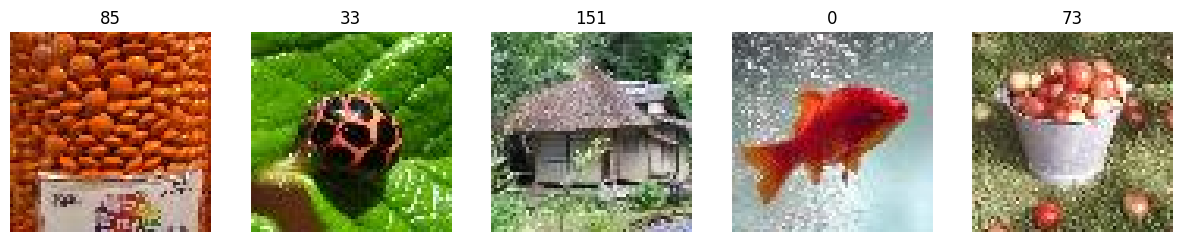

In [ ]:
show_images(xb[:5], ncols=5, titles=list(yb[:5].numpy()))

In [ ]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3):
        super().__init__()
        padding = 1 if kernel_size == 3 else 0
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, padding=padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.leaky = nn.LeakyReLU(0.1)

    def forward(self, x): return self.leaky(self.bn(self.conv(x)))

class Darknet19(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            # Initial layers
            ConvBlock(3, 32),
            nn.MaxPool2d(2),
            ConvBlock(32, 64),
            nn.MaxPool2d(2),
            
            # First block
            ConvBlock(64, 128),
            ConvBlock(128, 64, kernel_size=1),
            ConvBlock(64, 128),
            nn.MaxPool2d(2),
            
            # Second block
            ConvBlock(128, 256),
            ConvBlock(256, 128, kernel_size=1),
            ConvBlock(128, 256),
            nn.MaxPool2d(2),
            
            # Third block
            ConvBlock(256, 512),
            ConvBlock(512, 256, kernel_size=1),
            ConvBlock(256, 512),
            ConvBlock(512, 256, kernel_size=1),
            ConvBlock(256, 512),
            nn.MaxPool2d(2),
            
            # Fourth block
            ConvBlock(512, 1024),
            ConvBlock(1024, 512, kernel_size=1),
            ConvBlock(512, 1024),
            ConvBlock(1024, 512, kernel_size=1),
            ConvBlock(512, 1024)
        )

    def forward(self, x): return self.features(x)
